# Deterministic Policy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Week 0: Action: no_bet, Odds: -285.0, Outcome: 1, Cumulative Reward: 0
Week 1: Action: bet, Odds: 1600.0, Outcome: -1, Cumulative Reward: -100
Week 2: Action: no_bet, Odds: 290.0, Outcome: -1, Cumulative Reward: -100
Week 3: Action: no_bet, Odds: 1200.0, Outcome: -1, Cumulative Reward: -100
Week 4: Action: bet, Odds: 340.0, Outcome: 1, Cumulative Reward: 240.0
Week 5: Action: no_bet, Odds: 550.0, Outcome: -1, Cumulative Reward: 240.0
Week 6: Action: no_bet, Odds: 1300.0, Outcome: -1, Cumulative Reward: 240.0
Week 7: Action: bet, Odds: 400.0, Outcome: 1, Cumulative Reward: 640.0
Week 8: Action: no_bet, Odds: 850.0, Outcome: -1, Cumulative Reward: 640.0
Week 9: Action: no_bet, Odds: 210.0, Outcome: -1, Cumulative Reward: 640.0
Week 10: Action: no_bet, Odds: 1100.0, Outcome: -1, Cumulative Reward: 640.0


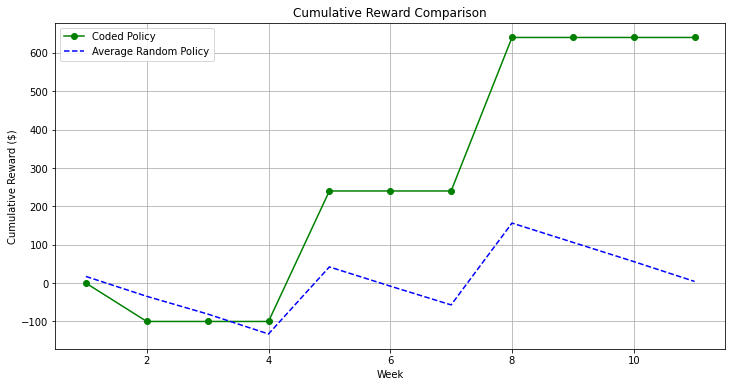

Times Coded Policy Beats Random Policies: 994


In [2]:
#Load data
data_df = pd.read_csv('./Data/2023/concat_stanford_2023.csv')

# Parameters
actions = ['bet', 'no_bet']
bet_amount = 100
expected_value_threshold = 5
num_simulations = 1000

# Define the reward function based on the bet outcome and odds
def reward(action, odds, outcome):
    if action == 'bet':
        if outcome > 0:  # Win scenario
            if odds > 0:
                return bet_amount * (odds / 100)  # Positive odds
            else:
                return bet_amount * (100 / abs(odds))  # Negative odds
        else:
            return -bet_amount  # Loss scenario
    return 0  # No reward if no bet

# Function to extract Stanford's moneyline odds and determine game outcome
def get_stanford_moneyline_and_outcome(row):
    if row['HomeTeam'] == 'Stanford':
        odds = row['HomeMoneyline']
        outcome = 1 if row['HomeScore'] > row['AwayScore'] else -1
        stanford_elo = row['Home Pregame Elo']
        opponent_elo = row['Away Pregame Elo']
    elif row['AwayTeam'] == 'Stanford':
        odds = row['AwayMoneyline']
        outcome = 1 if row['AwayScore'] > row['HomeScore'] else -1
        stanford_elo = row['Away Pregame Elo']
        opponent_elo = row['Home Pregame Elo']
    else:
        odds, outcome, stanford_elo, opponent_elo = None, None, None, None
    return odds, outcome, stanford_elo, opponent_elo

# Expected value calculation
def calculate_expected_value(odds, win_prob):
    if odds > 0:
        return bet_amount * (win_prob * (odds / 100) - (1 - win_prob))
    else:
        return bet_amount * (win_prob * (100 / abs(odds)) - (1 - win_prob))

# Simple policy to decide action based on Elo ratings comparison and expected value
def decide_action(row):
    odds, outcome, stanford_elo, opponent_elo = get_stanford_moneyline_and_outcome(row)
    if odds is None:
        return 'no_bet', 0  # Skip if Stanford did not play
    
    # Calculate win probability based on the Elo rating difference
    elo_diff = stanford_elo - opponent_elo
    win_prob = 1 / (1 + 10 ** (-elo_diff / 400))
    
    # Calculate expected value
    ev = calculate_expected_value(odds, win_prob)
    
    # Decision based on expected value
    if ev >= expected_value_threshold:
        return 'bet', odds
    else:
        return 'no_bet', odds

# Simulate the coded policy
coded_rewards = []
total_reward = 0
for week in range(len(data_df)):
    next_state = data_df.iloc[week]
    action, odds = decide_action(next_state)
    odds, outcome, _, _ = get_stanford_moneyline_and_outcome(next_state)
    week_reward = reward(action, odds, outcome)
    total_reward += week_reward
    coded_rewards.append(total_reward)
    print(f"Week {week}: Action: {action}, Odds: {odds}, Outcome: {outcome}, Cumulative Reward: {total_reward}")

# Simulate random policies
random_rewards = np.zeros((num_simulations, len(data_df)))
for sim in range(num_simulations):
    total_reward = 0
    for week in range(len(data_df)):
        next_state = data_df.iloc[week]
        odds, outcome, _, _ = get_stanford_moneyline_and_outcome(next_state)
        action = np.random.choice(actions)  # Random policy
        week_reward = reward(action, odds, outcome)
        total_reward += week_reward
        random_rewards[sim, week] = total_reward

# Calculate statistics
avg_random_rewards = random_rewards.mean(axis=0)
times_coded_beats_random = np.sum(coded_rewards[-1] > random_rewards[:, -1])

# Plot results
weeks = list(range(1, len(coded_rewards) + 1))
plt.figure(figsize=(12, 6))
plt.plot(weeks, coded_rewards, label="Coded Policy", marker='o', linestyle='-', color='g')
plt.plot(weeks, avg_random_rewards, label="Average Random Policy", linestyle='--', color='b')
plt.title("Cumulative Reward Comparison")
plt.xlabel("Week")
plt.ylabel("Cumulative Reward ($)")
plt.legend()
plt.grid(True)
plt.show()

print("Times Coded Policy Beats Random Policies:", times_coded_beats_random)

# Q-Learning

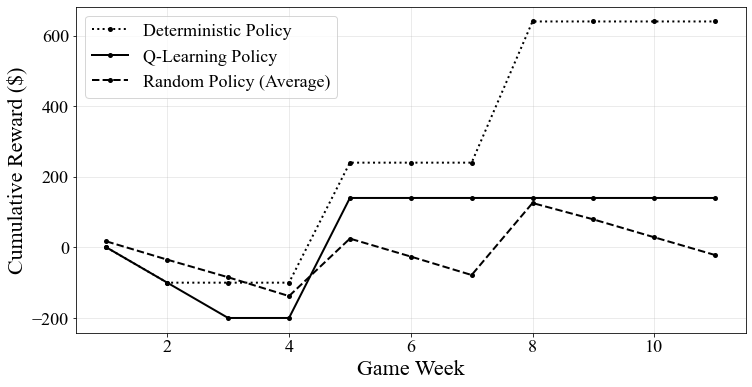

Q-learning beats Random Policy in 700/1000 simulations.
Q-learning Total Reward: 140.0
Random Policy Average Reward: 6.345518341307807
Random Policy Standard Deviation: 224.15120946719549

Q-learning Decisions for Each Game Week:
 Week          Action  Reward
    1          No Bet     0.0
    2 Bet on Stanford  -100.0
    3 Bet on Stanford  -100.0
    4          No Bet     0.0
    5 Bet on Stanford   340.0
    6          No Bet     0.0
    7          No Bet     0.0
    8          No Bet     0.0
    9          No Bet     0.0
   10          No Bet     0.0
   11          No Bet     0.0


In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data
training_data_path = './data/training_data.csv'
season_2024_data_path = './data/2023/concat_stanford_2023.csv'

training_data = pd.read_csv(training_data_path)
season_2024_data = pd.read_csv(season_2024_data_path)

# Define all columns to use as features (state space)
state_columns = [
    'Offense Ppa', 'Offense TotalPPA', 'Offense SuccessRate', 'Offense Explosiveness', 'Offense PowerSuccess',
    'Offense StuffRate', 'Offense LineYards', 'Offense LineYardsTotal', 'Offense SecondLevelYards',
    'Offense SecondLevelYardsTotal', 'Offense OpenFieldYards', 'Offense OpenFieldYardsTotal',
    'Offense StandardDowns Ppa', 'Offense StandardDowns SuccessRate', 'Offense StandardDowns Explosiveness',
    'Offense PassingDowns Ppa', 'Offense PassingDowns SuccessRate', 'Offense PassingDowns Explosiveness',
    'Offense RushingPlays Ppa', 'Offense RushingPlays TotalPPA', 'Offense RushingPlays SuccessRate',
    'Offense RushingPlays Explosiveness', 'Offense PassingPlays Ppa', 'Offense PassingPlays TotalPPA',
    'Offense PassingPlays SuccessRate', 'Offense PassingPlays Explosiveness', 'Defense Plays', 'Defense Drives',
    'Defense Ppa', 'Defense TotalPPA', 'Defense SuccessRate', 'Defense Explosiveness', 'Defense PowerSuccess',
    'Defense StuffRate', 'Defense LineYards', 'Defense LineYardsTotal', 'Defense SecondLevelYards',
    'Defense SecondLevelYardsTotal', 'Defense OpenFieldYards', 'Defense OpenFieldYardsTotal',
    'Defense StandardDowns Ppa', 'Defense StandardDowns SuccessRate', 'Defense StandardDowns Explosiveness',
    'Defense PassingDowns Ppa', 'Defense PassingDowns SuccessRate', 'Defense PassingDowns Explosiveness',
    'Defense RushingPlays Ppa', 'Defense RushingPlays TotalPPA', 'Defense RushingPlays SuccessRate',
    'Defense RushingPlays Explosiveness', 'Defense PassingPlays Ppa', 'Defense PassingPlays TotalPPA',
    'Defense PassingPlays SuccessRate', 'Defense PassingPlays Explosiveness', 'Home Pregame Elo',
    'Away Pregame Elo', 'Spread', 'OverUnder', 'HomeMoneyline', 'AwayMoneyline',
    'fumblesRecovered', 'rushingTDs', 'punReturnTDs', 'puntReturns', 'passingTDs', 'kickReturnYards',
    'kickReturnTDs', 'kickReturns', 'kickingPoints', 'interceptionYards', 'interceptionTDs', 'passesIntercepted',
    'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries', 'passesDeflected', 'possessionTime',
    'interceptions', 'fumblesLost', 'turnovers', 'totalPenaltiesYards', 'yardsPerRushAttempt', 
    'rushingAttempts', 'rushingYards', 'yardsPerPass', 'completionAttempts', 'netPassingYards', 'totalYards',
    'fourthDownEff', 'thirdDownEff', 'firstDowns', 'totalFumbles', 'Outcome', 'IsHome'
]

state_columns = [col for col in state_columns if col in training_data.columns]

training_data_relevant = training_data[state_columns].copy()
season_2024_relevant = season_2024_data[state_columns].copy()

training_data_relevant["IsHome"] = training_data["Team"] == training_data["Home Team"]
season_2024_relevant["IsHome"] = season_2024_data["Team"] == season_2024_data["Home Team"]

# Conversion function
def convert_fraction_to_float(value):
    try:
        if isinstance(value, str) and '-' in value:
            numerator, denominator = map(float, value.split('-'))
            return numerator / denominator if denominator != 0 else 0  # Avoid division by zero
        else:
            return float(value)
    except ValueError:
        return np.nan  # Handle invalid values

# List of columns to check for fractions
fraction_columns = ['totalPenaltiesYards', 'completionAttempts', 'fourthDownEff']  # Add other columns with this issue if needed

# Apply conversion
for col in fraction_columns:
    training_data_relevant[col] = training_data_relevant[col].apply(convert_fraction_to_float)
    season_2024_relevant[col] = season_2024_relevant[col].apply(convert_fraction_to_float)

# Fill missing values (e.g., from invalid conversions)
training_data_relevant = training_data_relevant.fillna(0)
season_2024_relevant = season_2024_relevant.fillna(0)

# Normalize the state features
scaler = MinMaxScaler()
training_data_normalized = scaler.fit_transform(training_data_relevant[state_columns])
season_2024_normalized = scaler.transform(season_2024_relevant[state_columns])

# Initialize the Q-table
num_states = training_data_normalized.shape[0]
num_actions = 2
q_table = np.zeros((num_states, num_actions))

# Define the reward function
def calculate_reward(is_home, home_moneyline, away_moneyline, outcome, action):
    if action == 0:
        return 0
    moneyline = home_moneyline if is_home else away_moneyline
    if outcome == 1:
        return abs(100 / moneyline) * 100 if moneyline < 0 else (moneyline / 100) * 100
    else:
        return -100

# Q-learning training
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

for episode in range(1000):
    for i, row in enumerate(training_data_normalized):
        state = i
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1])
        else:
            action = np.argmax(q_table[state, :])

        original_row = training_data_relevant.iloc[state]
        reward = calculate_reward(
            original_row["IsHome"], original_row["HomeMoneyline"], original_row["AwayMoneyline"], original_row["Outcome"], action
        )
        next_state = state + 1 if state + 1 < num_states else state
        q_table[state, action] += learning_rate * (
            reward + discount_factor * np.max(q_table[next_state, :]) - q_table[state, action]
        )

# Simulation of the 2024 season
def simulate_season(policy, data, log_decisions=False):
    total_reward = 0
    decisions = []
    for i, row in enumerate(data):
        action = policy(i, q_table)  # Policy determines action
        original_row = season_2024_relevant.iloc[i]
        reward = calculate_reward(
            original_row["IsHome"], original_row["HomeMoneyline"], original_row["AwayMoneyline"], original_row["Outcome"], action
        )
        total_reward += reward
        if log_decisions:
            decisions.append({
                "Week": i + 1,
                "Action": "Bet on Stanford" if action == 1 else "No Bet",
                "Reward": reward
            })
    return total_reward, decisions

# Q-learning policy
def q_learning_policy(state, q_table):
    return np.argmax(q_table[state, :])

# Random policy
def random_policy(state, q_table):
    return np.random.choice([0, 1])

# Compare Q-learning vs Random
q_learning_rewards, q_learning_decisions = simulate_season(q_learning_policy, season_2024_normalized, log_decisions=True)
# Simulate the season and collect rewards for Random policy across multiple runs
random_rewards_per_week = []

# Run simulations for Random policy
for _ in range(1000):
    _, random_decisions = simulate_season(random_policy, season_2024_normalized, log_decisions=True)
    rewards_for_one_run = [decision["Reward"] for decision in random_decisions]
    random_rewards_per_week.append(rewards_for_one_run)

# Convert to numpy array for easier averaging
random_rewards_per_week = np.array(random_rewards_per_week)

# Calculate the average cumulative reward per week across all random simulations
average_random_rewards = np.mean(random_rewards_per_week, axis=0)
cumulative_random_rewards = np.cumsum(average_random_rewards)

# Cumulative rewards for Q-learning
q_learning_cumulative_rewards = np.cumsum([decision["Reward"] for decision in q_learning_decisions])

plt.figure(figsize=(12, 6))

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Plot cumulative rewards for Deterministic policy with markers
plt.plot(
    range(1, len(coded_rewards) + 1),
    coded_rewards,
    label="Deterministic Policy",
    color="black",
    linestyle=":",
    linewidth=2,
    marker='o',  # Adding triangle markers
    markersize=3,
    markerfacecolor='black',  # Color of the marker's fill
    markeredgewidth=2
)

# Plot cumulative rewards for Q-learning with markers
plt.plot(
    range(1, len(q_learning_cumulative_rewards) + 1),
    q_learning_cumulative_rewards,
    label="Q-Learning Policy",
    color="black",
    linewidth=2,
    marker='o',  # Adding circular markers
    markersize=3,  # Size of the marker
    markerfacecolor='black',  # Color of the marker's fill
    markeredgewidth=2  # Marker border width
)

# Plot cumulative rewards for Random policy (averaged) with markers
plt.plot(
    range(1, len(cumulative_random_rewards) + 1),
    cumulative_random_rewards,
    label="Random Policy (Average)",
    color="black",
    linestyle="--",
    linewidth=2,
    marker='o',  # Adding square markers
    markersize=3,
    markerfacecolor='black',  # Color of the marker's fill
    markeredgewidth=2
)



# Add labels, title, and legend
plt.xlabel("Game Week", fontsize=22)
plt.ylabel("Cumulative Reward ($)", fontsize=22)
plt.legend(fontsize=18)
plt.grid(alpha=0.3)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig('./Figures/Reward-Time.png') 

# Display the plot
plt.show()

# Calculate statistics
# Total reward for Q-learning policy
q_learning_total_reward = sum([decision["Reward"] for decision in q_learning_decisions])

# Average total reward for random policy across all simulations
random_total_rewards = np.sum(random_rewards_per_week, axis=1)
average_random_reward = np.mean(random_total_rewards)

# Count how many random policy runs Q-learning beats
q_learning_better_count = sum(q_learning_total_reward > r for r in random_total_rewards)

print(f"Q-learning beats Random Policy in {q_learning_better_count}/1000 simulations.")
print(f"Q-learning Total Reward: {q_learning_rewards}")
print(f"Random Policy Average Reward: {np.mean(random_rewards)}")
print(f"Random Policy Standard Deviation: {np.std(random_rewards)}")

# Print Q-learning decisions
q_learning_decisions_df = pd.DataFrame(q_learning_decisions)
print("\nQ-learning Decisions for Each Game Week:")
print(q_learning_decisions_df.to_string(index=False))

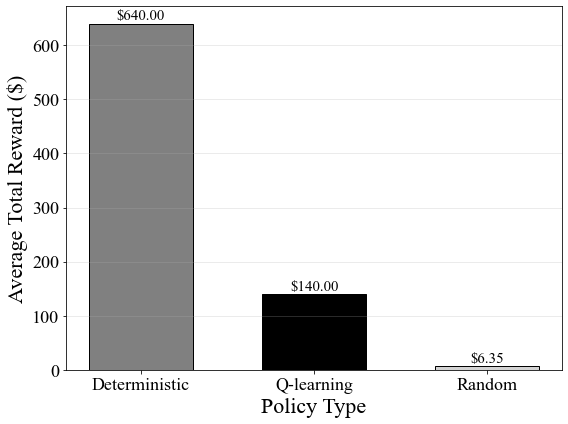

In [54]:
# Values for the bar graph
deterministic_reward = coded_rewards[-1]
q_learning_reward = q_learning_rewards
random_policy_reward = np.mean(random_rewards)

# Bar labels and corresponding rewards
labels = ['Deterministic', 'Q-learning', 'Random']
rewards = [deterministic_reward, q_learning_reward, random_policy_reward]

# Bar colors
colors = ['gray', 'black', 'lightgray']

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, rewards, color=colors, width=0.6, edgecolor='black')

# Add values above the bars
for i, reward in enumerate(rewards):
    plt.text(i, reward + 2, f"${reward:.2f}", ha='center', va='bottom', fontsize=15)

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Add labels, title, and grid
plt.ylabel("Average Total Reward ($)", fontsize=22)
plt.xlabel("Policy Type", fontsize=22)
plt.grid(axis='y', alpha=0.3)

# Display the plot
plt.tight_layout()

plt.savefig('./Figures/AvgReward.png') 

plt.show()